### Import All Library Dependencies

In [1]:
import os
import sys
import traceback
import logging as log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from microgrid_env import MicrogridEnv

log.basicConfig(format="Line:%(lineno)d-%(funcName)s-%(levelname)s:  %(message)s")
log.getLogger().setLevel(log.INFO)

### Data Pre-processing

In [2]:
df = pd.read_csv("load_profile_data_nov2024.csv", header=0)

In [3]:
df.head()

,entry_time,weekday,tou_time_slot,grid_import_energy,solar_prod_energy,solar_ctlr_setpoint,site_load_energy
0,11/1/24 0:00,Friday,o,1339.4,0.0,100.0,1339.4
1,11/1/24 1:00,Friday,o,1388.9,0.0,100.0,1388.9
2,11/1/24 2:00,Friday,o,1444.8,0.0,100.0,1444.8
3,11/1/24 3:00,Friday,o,1463.7,0.0,100.0,1463.7
4,11/1/24 4:00,Friday,o,1467.0,0.0,100.0,1467.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   entry_time           720 non-null    object 
 1   weekday              720 non-null    object 
 2   tou_time_slot        720 non-null    object 
 3   grid_import_energy   720 non-null    float64
 4   solar_prod_energy    720 non-null    float64
 5   solar_ctlr_setpoint  720 non-null    float64
 6   site_load_energy     720 non-null    float64
dtypes: float64(4), object(3)
memory usage: 39.5+ KB


In [5]:
df['timestamp'] = pd.to_datetime(df['entry_time'], format="mixed")

In [6]:
df['ts_hour'] = df['timestamp'].dt.hour

In [7]:
def convert_weekday(wkd: str) -> str:
    if wkd in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        return 'week'
    else:
        return wkd.lower()

In [8]:
# One-hot encode the Weekday field
df['weekday_fmt'] = df['weekday'].map(lambda wkd: convert_weekday(wkd))
df['day_week'] = df['weekday_fmt'].map(lambda wkd: 1 if wkd == 'week' else 0)
df['day_saturday'] = df['weekday_fmt'].map(lambda wkd: 1 if wkd == 'saturday' else 0)
df['day_sunday'] = df['weekday_fmt'].map(lambda wkd: 1 if wkd == 'sunday' else 0)

In [9]:
# One-hot encode the TOU Timeslot field
df['tou_offpeak'] = df['tou_time_slot'].map(lambda tou: 1 if tou == 'o' else 0)
df['tou_standard'] = df['tou_time_slot'].map(lambda tou: 1 if tou == 's' else 0)
df['tou_peak'] = df['tou_time_slot'].map(lambda tou: 1 if tou == 'p' else 0)

In [10]:
# Convert hour field to unit circle coordinates
df['ts_hour_sin'] = np.sin( df['ts_hour'] )
df['ts_hour_cos'] = np.cos( df['ts_hour'] )

In [11]:
df.set_index('timestamp', inplace=True)

In [12]:
df.drop(['entry_time', 'ts_hour', 'weekday', 'weekday_fmt', 'tou_time_slot'], axis=1, inplace=True)

In [13]:
load_profile_df = df[['ts_hour_sin', 'ts_hour_cos', 'tou_offpeak', 'tou_standard', 'tou_peak', 'day_week', 'day_saturday', 'day_sunday', 'site_load_energy', 'solar_prod_energy', 'solar_ctlr_setpoint', 'grid_import_energy']]

In [14]:
load_profile_df.head(48)

,ts_hour_sin,ts_hour_cos,tou_offpeak,tou_standard,tou_peak,day_week,day_saturday,day_sunday,site_load_energy,solar_prod_energy,solar_ctlr_setpoint,grid_import_energy
timestamp,,,,,,,,,,,,
2024-11-01 00:00:00,0.000000,1.000000,1,0,0,1,0,0,1339.40,0.00,100.000,1339.4
2024-11-01 01:00:00,0.841471,0.540302,1,0,0,1,0,0,1388.90,0.00,100.000,1388.9
2024-11-01 02:00:00,0.909297,-0.416147,1,0,0,1,0,0,1444.80,0.00,100.000,1444.8
2024-11-01 03:00:00,0.141120,-0.989992,1,0,0,1,0,0,1463.70,0.00,100.000,1463.7
2024-11-01 04:00:00,-0.756802,-0.653644,1,0,0,1,0,0,1467.00,0.00,100.000,1467.0
2024-11-01 05:00:00,-0.958924,0.283662,1,0,0,1,0,0,1402.91,24.21,100.000,1378.7
2024-11-01 06:00:00,-0.279415,0.960170,0,0,1,1,0,0,1458.70,173.80,100.000,1284.9
2024-11-01 07:00:00,0.656987,0.753902,0,0,1,1,0,0,1488.20,519.50,100.000,968.7
2024-11-01 08:00:00,0.989358,-0.145500,0,0,1,1,0,0,1442.50,851.60,100.000,590.9


In [15]:
load_profile_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ts_hour_sin,720.0,0.040825,0.697899,-0.999990,-0.595763,0.070560,0.701904,0.990607
ts_hour_cos,720.0,-0.022538,0.715646,-0.999961,-0.680155,-0.070537,0.683713,1.000000
tou_offpeak,720.0,0.443056,0.497092,0.000000,0.000000,0.000000,1.000000,1.000000
tou_standard,720.0,0.411111,0.492377,0.000000,0.000000,0.000000,1.000000,1.000000
tou_peak,720.0,0.145833,0.353184,0.000000,0.000000,0.000000,0.000000,1.000000
day_week,720.0,0.700000,0.458576,0.000000,0.000000,1.000000,1.000000,1.000000
day_saturday,720.0,0.166667,0.372937,0.000000,0.000000,0.000000,0.000000,1.000000
day_sunday,720.0,0.133333,0.340171,0.000000,0.000000,0.000000,0.000000,1.000000
site_load_energy,720.0,1243.478583,327.529219,0.000000,1063.915000,1322.400000,1488.250000,1934.700000
solar_prod_energy,720.0,306.043861,414.502550,0.000000,0.000000,36.000000,561.375000,1443.100000


In [16]:
load_profile_filtered_df = load_profile_df.loc['2024-11-04':'2024-11-10']

In [17]:
load_profile_filtered_df.head()

,ts_hour_sin,ts_hour_cos,tou_offpeak,tou_standard,tou_peak,day_week,day_saturday,day_sunday,site_load_energy,solar_prod_energy,solar_ctlr_setpoint,grid_import_energy
timestamp,,,,,,,,,,,,
2024-11-04 00:00:00,0.000000,1.000000,1,0,0,1,0,0,1031.9,0.0,100.0,1031.9
2024-11-04 01:00:00,0.841471,0.540302,1,0,0,1,0,0,1191.1,0.0,100.0,1191.1
2024-11-04 02:00:00,0.909297,-0.416147,1,0,0,1,0,0,1233.8,0.0,100.0,1233.8
2024-11-04 03:00:00,0.141120,-0.989992,1,0,0,1,0,0,1145.3,0.0,100.0,1145.3
2024-11-04 04:00:00,-0.756802,-0.653644,1,0,0,1,0,0,1247.1,0.0,100.0,1247.1


In [18]:
load_profile_filtered_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ts_hour_sin,168.0,0.040825,0.699499,-0.999990,-0.595763,0.070560,0.701904,0.990607
ts_hour_cos,168.0,-0.022538,0.717287,-0.999961,-0.680155,-0.070537,0.683713,1.000000
tou_offpeak,168.0,0.446429,0.498608,0.000000,0.000000,0.000000,1.000000,1.000000
tou_standard,168.0,0.404762,0.492313,0.000000,0.000000,0.000000,1.000000,1.000000
tou_peak,168.0,0.148810,0.356965,0.000000,0.000000,0.000000,0.000000,1.000000
day_week,168.0,0.714286,0.453104,0.000000,0.000000,1.000000,1.000000,1.000000
day_saturday,168.0,0.142857,0.350973,0.000000,0.000000,0.000000,0.000000,1.000000
day_sunday,168.0,0.142857,0.350973,0.000000,0.000000,0.000000,0.000000,1.000000
site_load_energy,168.0,1154.939940,304.294259,534.680000,1036.775000,1217.150000,1377.600000,1652.700000
solar_prod_energy,168.0,224.364345,337.372179,0.000000,0.000000,18.125000,324.887500,1266.300000


### Create Microgrid Environment

In [19]:
env = MicrogridEnv(data=load_profile_filtered_df)

Environment Defaults: 

      Grid Notified Maximum Demand: 2000.0 kVA
      BESS Capacity: 3000.0 kWh
      BESS Actions: charge-1500, charge-1000, charge-500, do-nothing, discharge-500, discharge-1000, discharge-1500
      Reward Discount Factor: 0.99
      

Data Summary: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2024-11-04 00:00:00 to 2024-11-10 23:00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ts_hour_sin          168 non-null    float64
 1   ts_hour_cos          168 non-null    float64
 2   tou_offpeak          168 non-null    int64  
 3   tou_standard         168 non-null    int64  
 4   tou_peak             168 non-null    int64  
 5   day_week             168 non-null    int64  
 6   day_saturday         168 non-null    int64  
 7   day_sunday           168 non-null    int64  
 8   site_load_energy     168 non-null    float64
 9   solar_prod_energy    168 n

### Run Environment

In [20]:
epsilon = 0.2
reward_buffer = []


state, reward, done = env.reset()

while(not done):

    reward_buffer.append(reward)

    if np.random.random() <= epsilon:

        action = np.random.choice(7)
        
    else:
        
        action = env.rule_based_policy(state=state)

    state, reward, done = env.step(action=action)


      [0] Environment State ->
              hour_sin:  0.0000
              hour_cos:  1.0000
              tou_offpeak:  1
              tou_standard:  0
              tou_peak:  0
              day_week:  1
              day_saturday:  0
              day_sunday:  0
              site_load_energy:  1031.90 (kWh)
              solar_prod_energy:  0.00 (kWh)
              solar_ctlr_setpoint:  100.00 (%)
              solar_vs_load_ratio:  0.00 (%)
              grid_import_energy:  1031.90 (kWh)
              bess_avail_discharge_energy:  3000.00 (kWh)
              done: False
      
 
      [0] Selected Action -> charge-500
      
 
      [0] Reward ->  0.000
      

      [1] Environment State ->
              hour_sin:  0.8415
              hour_cos:  0.5403
              tou_offpeak:  1
              tou_standard:  0
              tou_peak:  0
              day_week:  1
              day_saturday:  0
              day_sunday:  0
              site_load_energy:  1191.10 (kWh)
  

### Display Results

In [21]:
print(f"Final Reward: {reward: .2f}k")

Final Reward:  23.19k


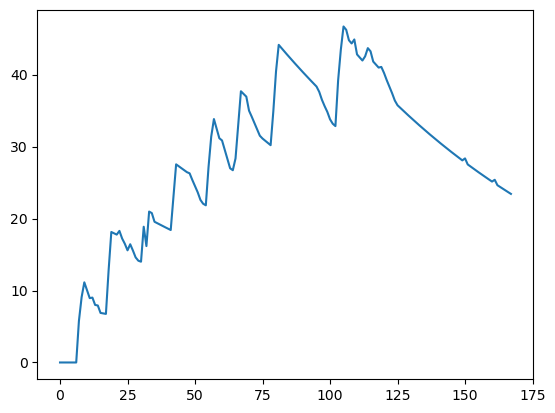

In [22]:
y = np.array(reward_buffer)
x = range( y.shape[0] )
plt.plot(x, y)